Active Contours using Level Sets
================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This tour explores image segementation using level set methods.

In [1]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Managing level set functions
----------------------------
In the level set formalism, the evolution of some curve $ (\ga(t))_{t=0}^1 $
is computed by evolving the
zero level of a function $\phi : \RR^2 \rightarrow \RR $
$$ \enscond{\ga(s)}{ s \in [0,1] } = \enscond{x \in \RR^2}{\phi(x)=0}. $$
This corresponds to replacing the parameteric representation $\ga$ of
the curve by an implicit representation. This requires an additional
dimension (and hence more storage) but ease the handling of topological
change of the curve during the evolution.


Discretazion size $n \times n$ of the domain $[0,1]^2$.

In [2]:
n = 200
Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))

One can create a circular shape by using the signed distance function to
a circle
$$ \phi_1(x) = \sqrt{ (x_1-c_1)^2 + (x_2-c_2)^2 } - r $$
where $r>0$ is the radius and $c \in \RR^2$ the center.


Radius $r$.

In [3]:
r = n/3.

Center $c$.

In [4]:
c = np.array([r,r]) + 10

Distance function $\phi_1$.

In [5]:
phi1 = np.sqrt((X-c[0])**2 + (Y-c[1])**2) - r

__Exercise 1__

Load a square shape $\phi_2$ at a different position for the center.

In [6]:
run -i nt_solutions/segmentation_3_snakes_levelset/exo1

In [7]:
## Insert your code here.

Display the curves associated to $\phi_1$ and $\phi_2$.

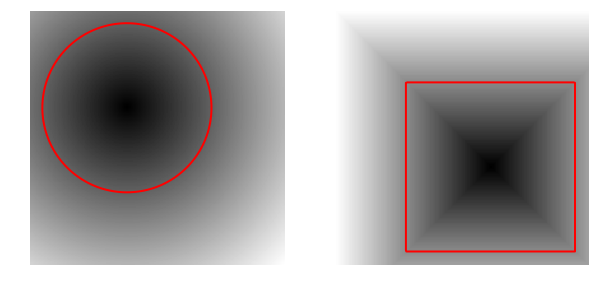

In [8]:
from nt_toolbox.plot_levelset import *
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plot_levelset(phi1)

plt.subplot(1,2,2)
plot_levelset(phi2)

__Exercise 2__

Compute the intersection and the union of the two shapes.
Store the union in $\phi_0$ (phi0)
that we will use in the remaining part of the tour.

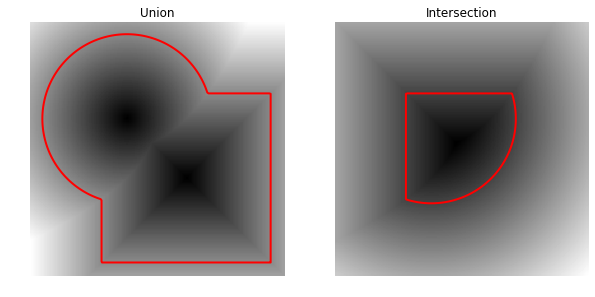

In [9]:
run -i nt_solutions/segmentation_3_snakes_levelset/exo2

In [10]:
## Insert your code here.

Mean Curvature Motion.
----------------------
The mean curvature motion corresponds to the minimizing flow of the
length of the curve
$$ \int_0^1 \norm{\ga'(s)} d s. $$



It is implemeted in a level set formalism by a familly $\phi_t$ of
level set function parameterized by an artificial time $t \geq 0$, that
satisfies the following PDE
$$ \pd{\phi_t}{t} = -G(\phi_t)
  \qwhereq G(\phi) = -\norm{\nabla \phi} \text{div}
      \pa{  \frac{\nabla \phi}{\norm{\nabla \phi}} }  $$
and where $\nabla \phi_t(x) \in \RR^2$ is the spacial gradient.


This flow is computed using a gradient descent
$\phi^{(0)} = \phi_0$ and
$$ \phi^{(\ell+1)} = \phi^{(\ell)} - \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough time step.


Maximum time of the evolution $0 \leq t \leq t_{\max}$.

In [11]:
Tmax = 200

Time step $\tau>0$ (should be small).

In [12]:
tau = .5

Number of iterations.

In [13]:
niter = int(Tmax/tau)

Initial shape $\phi^{(0)}$ at $t=0$.

In [14]:
phi = np.copy(phi0)

We now compute the right hand side of the evolution equation.


Compute the gradient $\nabla \phi$. We use centered differences for the discretization of the gradient.

In [15]:
from nt_toolbox.grad import *
g0 = grad(phi, order=2)

Norm $\norm{\nabla \phi}$ of the gradient.

In [16]:
eps = np.finfo(float).eps
d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(g0**2, 2)))

Normalized gradient.

In [17]:
g = g0/np.repeat(d[:,:,np.newaxis], 2, 2)

The curvature term.

In [18]:
from nt_toolbox.div import *
K = - d*div(g[:,:,0], g[:,:,1], order=2)

Perform one step of the gradient descent.

In [19]:
phi = phi - tau*K

__Exercise 3__

Implement the mean curvature motion.

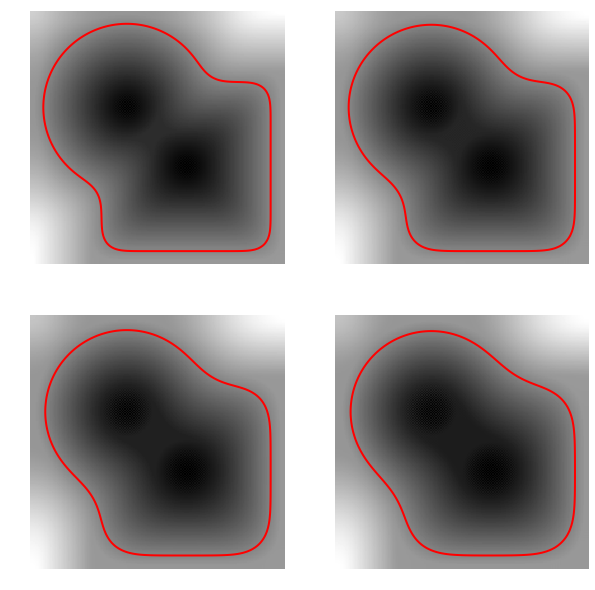

In [20]:
run -i nt_solutions/segmentation_3_snakes_levelset/exo3

In [21]:
## Insert your code here.

Levelset Re-distancing
----------------------
During PDE resolution, a level set function $\phi$ might become
ill-conditionned, so that the zero crossing is not sharp enough.
The quality of the level set function is restored by computing the
signed distance function to the zero level set.



This corresponds to first extracting the zero level set
$$ \Cc = \enscond{x \in \RR^2 }{\phi(x)=0},  $$
and then solving the following eikonal equation PDE on $\tilde \phi$
(in viscosity sense)
$$ \norm{\nabla \tilde \phi(x)} = 1
      \qandq \forall y \in \Cc, \tilde\phi(y)=0. $$
The one can replace $\phi$ by $\text{sign}(\phi(x))\tilde \phi(x)$
which is the signed distance function to $\Cc$.


We set $\phi=\phi_0^3$ so that they are both valid level set function
of the same curve, but $\phi$ is not the signed distance function.

In [22]:
phi = phi0**3

Solve the eikonal PDE using the Fast Marching algorithm. You have to install a C++ compiler (https://wiki.python.org/moin/WindowsCompilers#Microsoft_Visual_C.2B-.2B-_14.0_standalone:_Visual_C.2B-.2B-_Build_Tools_2015_.28x86.2C_x64.2C_ARM.29) and the package scikit-fmm (skfmm) to run this function (pip install scikit_fmm in the console).

In [23]:
from nt_toolbox.perform_redistancing import *
phi1 = perform_redistancing(phi0)

Display the level sets.

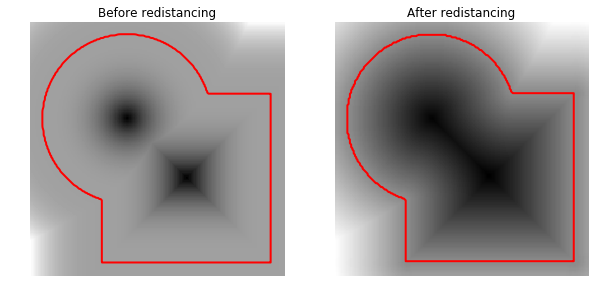

In [24]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plot_levelset(phi)
plt.title("Before redistancing")

plt.subplot(1,2,2)
plot_levelset(phi1)
plt.title("After redistancing")

plt.show()

Edge-based Segmentation with Geodesic Active Contour
----------------------------------------------------
Geodesic active contours compute loval minimum of a weighted geodesic
distance that attract the curve toward the features of the background
image.


_Note:_ these active contours should not be confounded with the geodesic shortest paths,
that are globally minimizing geodesics between two points.
Here the active contour is a close curve progressively decreasing a
weighted geodesic length that is only a local minimum
(the global minimum would be a single point).


Size of the image.

In [25]:
n = 200

First we load an image $f_0 \in \RR^{n \times n}$ to segment.

In [26]:
f0 = rescale(load_image("nt_toolbox/data/cortex.bmp", n))

Given a background image $f_0$ to segment, one needs to compute
an edge-stopping function $W$.
It should be small in area of high gradient, and high in area of large gradient.


We use here
$$ W(x) = \al + \frac{\be}{\epsilon + d(x) }
      \qwhereq d = \norm{\nabla f_0} \star h_a, $$
and where $h_a$ is a blurring kernel of size $a>0$.


Compute the magnitude of the gradient $d_0(x) = \norm{\nabla f_0(x)}$.

In [27]:
g = grad(f0, order=2)
d0 = np.sqrt(np.sum(g**2, 2))

Blur size $a$.

In [28]:
a = 5

Compute the blurring $d = d_0 \star h_a$.

In [29]:
from nt_toolbox.perform_blurring import *
d = perform_blurring(d0, np.asarray([a]),bound="per")

Parameter $\epsilon>0$.

In [30]:
epsilon = 1e-1

We set the $\al$ and $\be$ parameters to adjust the overall values of $W$
(equivalently we use the function rescale).

In [31]:
W = 1./(epsilon + d)
W = rescale(-d, 0.1, 1)

Display it.

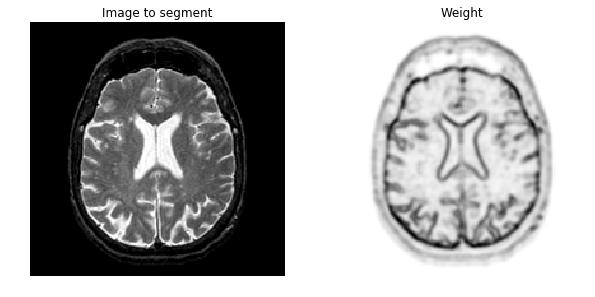

In [32]:
plt.figure(figsize=(10,5))
imageplot(f0, "Image to segment", [1,2,1])
imageplot(W, "Weight", [1,2,2])

__Exercise 4__

Compute an initial shape $\phi_0$ at time $t=0$,
for instance a centered square.

In [33]:
run -i nt_solutions/segmentation_3_snakes_levelset/exo4

In [34]:
## Insert your code here.

Display it.

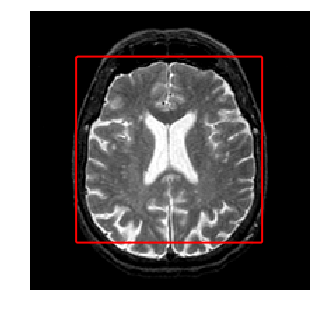

In [35]:
plt.figure(figsize=(5,5))
plot_levelset(phi0, 0, f0)

The geodesic active contour minimizes a weighted length of curve
$$ \umin{\ga} \int_0^1 \norm{\ga'(s)} W(\ga(s)) d s $$


The level set implementation of the gradient descent of this energy reads
$$ \pd{\phi_t}{t} = G(\phi_t)
  \qwhereq G(\phi) = -\norm{\nabla \phi} \text{div}\pa{
          W \frac{\nabla \phi}{\norm{\nabla \phi}}
  } $$


This is implemented using a gradient descent scheme.
$$ \phi^{(\ell+1)} = \phi^{(\ell)} - \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough.


Gradient step size $\tau>0$.

In [36]:
tau = .4

Final time and number of iteration of the algorithm.

In [37]:
Tmax = 1500
niter = int(Tmax/tau)

Initial distance function $\phi^{(0)}=\phi_0$.

In [38]:
phi = np.copy(phi0)

Note that we can re-write the gradient of the energy as
$$ G(\phi) = -W \norm{\nabla \phi} \text{div} \pa{ \frac{\nabla \phi}{\norm{\nabla \phi}}  } - \dotp{\nabla W}{\nabla \phi} $$


Pre-compute once for all $\nabla W$.

In [39]:
gW = grad(W, order=2)

__Exercise 5__

Compute and store in G the gradient $G(\phi)$ (right hand side of the PDE)
using the current value of the distance function $\phi$.

In [40]:
run -i nt_solutions/segmentation_3_snakes_levelset/exo5

In [41]:
## Insert your code here.

Do the descent step.

In [42]:
phi = phi - tau*G

Once in a while (e.g. every 30 iterations), perform re-distancing of $\phi$.

In [43]:
phi = perform_redistancing(phi)

__Exercise 6__

Implement the geodesic active contours gradient descent.
Do not forget to do the re-distancing.

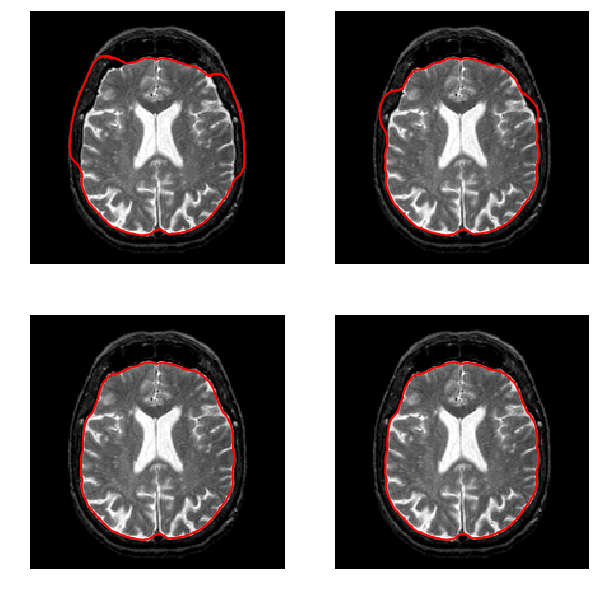

In [44]:
run -i nt_solutions/segmentation_3_snakes_levelset/exo6

In [45]:
## Insert your code here.

Region-based Segmentation with Chan-Vese 
-----------------------------------------
Chan-Vese active contours corresponds to a region-based energy
that looks for a piecewise constant approximation of the image.


The energy to be minimized is
$$ \umin{\phi}
      L(\phi) +
      \la \int_{\phi(x)>0} \abs{f_0(x)-c_1}^2 d x   +
      \la \int_{\phi(x)<0} \abs{f_0(x)-c_2}^2 d x
$$
where $L$ is the length of the zero level set of $\phi$.
Note that here $(c_1,c_2) \in \RR^2$ are assumed to be known.

__Exercise 7__

Compute an initial level set function $\phi_0$, stored in phi0,
for instance many small circles.

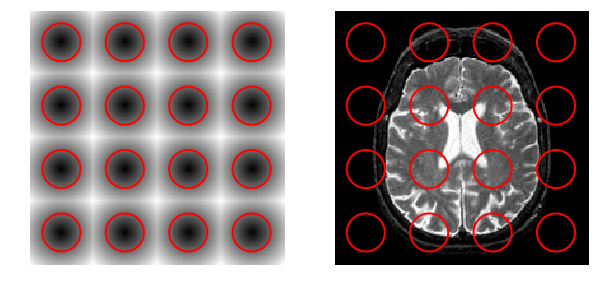

In [46]:
run -i nt_solutions/segmentation_3_snakes_levelset/exo7

In [47]:
## Insert your code here.

Parameter $\la$

In [48]:
lambd = 2

Values for $c_1,c_2$

In [49]:
c1 = .7
c2 = 0

Step size.

In [50]:
tau = .5

Number of iterations.

In [51]:
Tmax = 100
niter = int(Tmax/ tau)

Initial distance function $\phi_0$ at time $t=0$.

In [52]:
phi = np.copy(phi0)

The minimizing flow for the CV energy reads
$$ \pd{\phi_t}{t} = - G(\phi_t) $$
where
$$ G(\phi) =
- W \norm{\nabla \phi} \text{div}\pa{
	\frac{\nabla \phi}{\norm{\nabla \phi}}
} + \la (f_0-c_1)^2 - \la (f_0-c_2)^2. $$

__Exercise 8__

Compute this gradient $G(\phi)$ using the current value of the distance function
(phi$.
radient

In [53]:
run -i nt_solutions/segmentation_3_snakes_levelset/exo8

In [54]:
## Insert your code here.

Do a descent step.

In [55]:
phi = phi + tau*G

__Exercise 9__

Implement the full gradient descent.

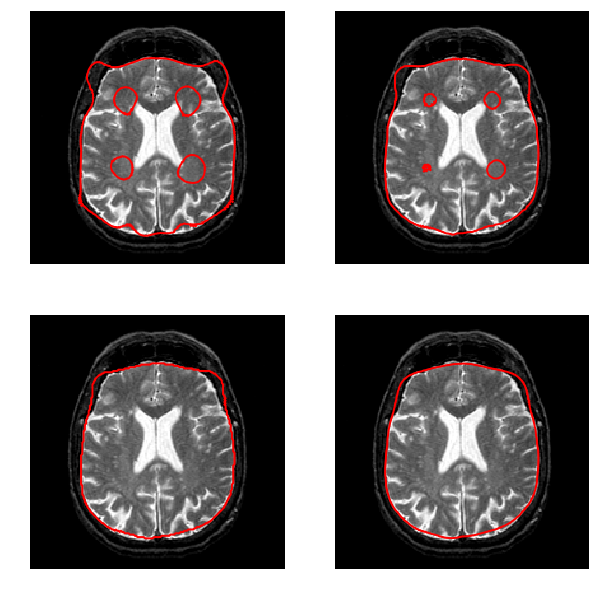

In [56]:
run -i nt_solutions/segmentation_3_snakes_levelset/exo9

In [57]:
## Insert your code here.